In [17]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs

device = 'cpu'

## Plot loss for different gammas with SS activity

In [23]:
experiment_dir = "../trained_models/02_gamma_v_ss/"
iterations = []
losses = []
exps = []

for gamma in os.listdir(experiment_dir):
    gamma_exp_dir = experiment_dir + f'{gamma}/'
    for gamma_iter in os.listdir(gamma_exp_dir):
        for file in os.listdir(gamma_exp_dir + gamma_iter):
            if 'tfevents' not in file: continue
            tfevents_file = gamma_exp_dir + gamma_iter + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                iterations.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                exps.append(gamma)
            break

iterations = np.array(iterations)
losses = np.array(losses)
exps = np.array(exps)

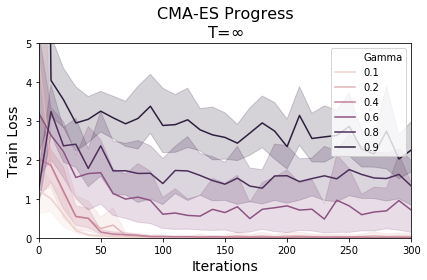

In [24]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Iterations': iterations, 'Loss': losses, 'Gamma': exps})
sns.lineplot(x='Iterations', y='Loss', hue='Gamma', legend='full', data=df)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)
plt.title('CMA-ES Progress\nT=$\infty$', fontsize=16)
plt.legend()
plt.tight_layout()
plt.xlim(0, 300)
plt.ylim(0, 5)
plt.savefig('gamma_v_ss.png', dpi=200)
plt.show()

## Plot loss for different gammas and recurrent steps

In [85]:
with open("../trained_models/02_gamma_v_rsteps/results.p", 'rb') as f:
    results = pickle.load(f)

In [80]:
gridsearch_dir = "../trained_models/02_gamma_v_rsteps/"
gamma_axes = []
rstep_axes = []
vals = []
results = {
    'gamma_axes': gamma_axes,
    'rstep_axes': rstep_axes,
    'vals': vals
}
for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    for rstep in os.listdir(gamma_dir):
        rstep_dir = gamma_dir + f'{rstep}/'
        for file in os.listdir(rstep_dir):
            if 'tfevents' not in file: continue
            tfevents_file = rstep_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            val = event_acc.Scalars('loss_train')[-1].value
            gamma_axes.append(gamma)
            rstep_axes.append(int(rstep))
            vals.append(val)
            break

In [86]:
results.keys()

dict_keys(['gamma_axes', 'rstep_axes', 'vals'])

In [87]:
xs = np.array(results['rstep_axes'])
ys = np.array(results['gamma_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

In [88]:
mat = np.zeros((xs.size, ys.size))*np.nan
for rstep, gamma, val in zip(
    results['rstep_axes'], results['gamma_axes'], results['vals']
    ):
    x_idx = np.argwhere(xs == rstep)[0,0]
    y_idx = np.argwhere(ys == gamma)[0,0]
    mat[x_idx][y_idx] = val

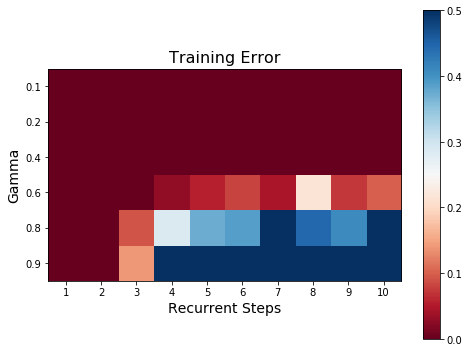

In [89]:
plt.figure(figsize=(7,5))
plt.imshow(mat.T, cmap="RdBu", vmax=0.5)
plt.yticks(np.arange(ys.size), ys)
plt.xticks(np.arange(xs.size), xs)
plt.xlabel('Recurrent Steps', fontsize=14)
plt.ylabel('Gamma', fontsize=14)
plt.colorbar()
plt.title("Training Error", fontsize=16)
plt.tight_layout()
plt.savefig("gamma_v_rsteps.png", dpi=300)
plt.show()